# DeepLabv3 transfer learning implementation


## Import pretrained model Deeplabv3

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.AlexNet_DeepLab import AlexNetDeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.ClassifierHead import DeepLabHead


In [2]:
transform_image = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])
transform_mask = transforms.Compose(
    [
     transforms.ToTensor()
     ])

path = 'G:/MachineLearning/liver-database/'
save_path = 'G:/MachineLearning/models/'
#path = 'segmentations/'
dataset_learn = LiverDataset(path + 'testing/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_learn = torch.utils.data.DataLoader(dataset_learn, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

dataset_test = LiverDataset(path + 'testing/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_test = torch.utils.data.DataLoader(dataset_learn, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

## Generam punctele de start pt model

In [3]:
model = AlexNetDeepLab()
for param in model.parameters():
    param.requires_grad = True

torch.save(model, "G:/MachineLearning/models/AlexNet_0.pt")

## Start training!

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'AlexNet'
start_epoch = 0
model_path = model_name + '_' + str(start_epoch) + '.pt'

if device==torch.device('cuda'):
    model = torch.load(save_path + model_path)
else:
    model = torch.load(save_path + model_path, map_location=torch.device('cpu'))
    
torch.cuda.empty_cache()

model = model.to(device)

optimizer = optim.SGD([
            {'params': model.parameters()}
            ], lr=0.04, momentum=0.9)
sched = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_fcn = nn.BCEWithLogitsLoss().to(device)

In [5]:
for t in range(10):
    print(f"Epoch {t + 1 + start_epoch}\n-------------------------------")
    
    train_loop(dataloader_learn, model, loss_fcn, optimizer, sched, device)
    
    validation_loss = test_loop(dataloader_learn, model, loss_fcn, device)
    sched.step()
    torch.save(model, save_path + model_name + '_' + str(t+1+start_epoch) +'.pt')

print("Done!")

Epoch 1
-------------------------------
loss: 0.587796  [    0/ 4776]
loss: 0.016111  [ 3200/ 4776]
Avg loss: 0.035781 

Epoch 2
-------------------------------
loss: 0.023248  [    0/ 4776]
loss: 0.011469  [ 3200/ 4776]
Avg loss: 0.021235 

Epoch 3
-------------------------------
loss: 0.015250  [    0/ 4776]
loss: 0.003281  [ 3200/ 4776]
Avg loss: 0.020668 

Epoch 4
-------------------------------
loss: 0.009742  [    0/ 4776]
loss: 0.009241  [ 3200/ 4776]
Avg loss: 0.014188 

Epoch 5
-------------------------------
loss: 0.013537  [    0/ 4776]
loss: 0.009671  [ 3200/ 4776]
Avg loss: 0.016532 

Epoch 6
-------------------------------
loss: 0.009238  [    0/ 4776]
loss: 0.006437  [ 3200/ 4776]
Avg loss: 0.018968 

Epoch 7
-------------------------------
loss: 0.011651  [    0/ 4776]
loss: 0.016458  [ 3200/ 4776]
Avg loss: 0.015070 

Epoch 8
-------------------------------
loss: 0.008349  [    0/ 4776]
loss: 0.008069  [ 3200/ 4776]
Avg loss: 0.013976 

Epoch 9
------------------------

## Vizualizam o imagine din dataset

torch.Size([1, 512, 512])
tensor(1.)


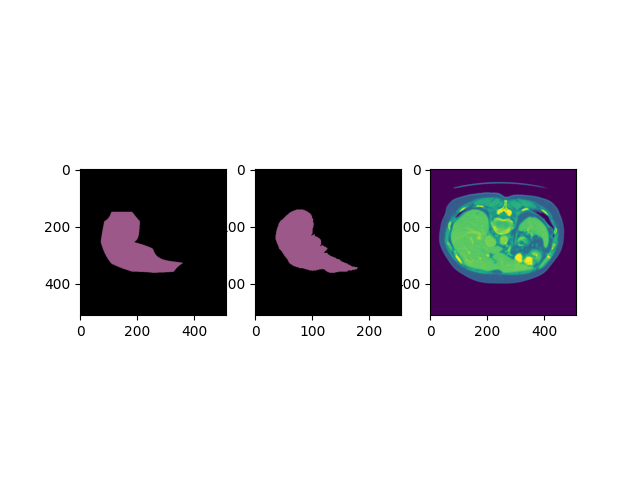

In [4]:
model_name = 'G:/MachineLearning/models/AlexNet/AlexNet_500.pt'
model = torch.load(model_name)
#model = model.module

device = torch.device('cpu')
model.to(device)
torch.cuda.empty_cache()

model.eval()
input_tensor, mask = dataset_learn.__getitem__(60)
input_batch = input_tensor.repeat(2, 1, 1, 1)
pred = model(input_batch.to(device))[0]

img, pred_x = deprocess_img(input_tensor, pred, 512)
img = np.transpose(img)


smax = nn.Sigmoid()
# output_predictions = pred_x
output_predictions = smax(pred_x)
print(output_predictions.shape)
output_predictions = np.transpose(output_predictions.cpu().squeeze())
output_predictions = np.round(output_predictions)
mask = np.transpose(mask.cpu().squeeze())

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(3)])[:, None] * 1.1 * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy())
r.putpalette(colors)

r_mask = Image.fromarray(mask.byte().cpu().numpy())
r_mask.putpalette(colors)

print(torch.max(output_predictions))
plt.subplot(1, 3, 1)
plt.imshow(r)
plt.subplot(1, 3, 2)
plt.imshow(r_mask)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
plt.show()